In [ ]:
# IMPORTS
from scipy.signal import find_peaks
from scipy.ndimage.measurements import label
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal as signal
from scipy.interpolate import interp1d
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, SpatialDropout1D,SpatialDropout2D,ReLU, LeakyReLU, Dense,Dropout, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing import image
import tensorflow as tf

In [ ]:
#define data_path

### predefined functions

In [ ]:
def find_row_peaks(col_mean, top_k=3):
    peaks = find_peaks(col_mean)[0] #find all peaks (indices)  (local maxima)   #, distance=100
    peaks_value = col_mean[peaks] #get the values of the peaks
    top_idx = np.sort(peaks_value.argsort()[-top_k:][::-1]) #order the inidces by peak value
    peaks = peaks[top_idx] #get the indices of the top peaks ordered?
    return peaks

In [ ]:
def find_row_range(values, sections):
  sub_values1 = values[sections[0]:sections[1] + 1] #get the values at the left side of peak
  sub_values2 = values[sections[1]:sections[2] + 1] #get the values at the right side of peak

  r1 = np.where(sub_values1 == np.min(sub_values1))[0][-1] #get the last index of the lowest value (last one before it starts to go up)
  r2 = np.where(sub_values2 == np.min(sub_values2))[0][0] #get the firt index of the lowest value (when it starts to go down)
  return r1 + sections[0], r2 + sections[1]   #contextualize it in the longer indices (not in the range of subvalues)

In [ ]:
def remove_small_objects(image_cp, threshold=100):
    # image_cp = image.copy()
    labeled_ch0, n_labels = label(image_cp, structure=np.ones((3, 3)))
    values, counts = np.unique(labeled_ch0, return_counts=True)
    for value, count in zip(values, counts):
        if count < threshold:
            image_cp[labeled_ch0 == value] = 0.0

    image_cp[image_cp > 0] = 1.0
    return image_cp

In [ ]:
def extract_signal(image):

    # median row as center row
    center_row = np.median(np.where(image == 1)[0])

    signal = []
    for col in range(image.shape[1]):
        labeled_c, nc_objs = label(image[:, col])
        if nc_objs < 1:
            signal.append(np.nan)
            continue
        else:
            labels_dis = []
            for i in range(1, nc_objs + 1):
                locs = np.where(labeled_c == i)[0]
                center_dis = np.abs(locs - center_row)
                labels_dis.append(np.min(center_dis))
            min_dis_label = np.argmin(labels_dis) + 1
            locs = np.where(labeled_c == min_dis_label)[0]
            center_dis = np.abs(locs - center_row)
            point_row = locs[np.argmax(center_dis)]
            point_value = center_row - point_row
            signal.append(np.max(point_value))
            # signal.append(np.mean(point_value))

       
    return np.array(signal)

In [ ]:
def image2signal(image, r1, r2):
    image_crop = image.copy()[r1:r2 + 1, :]
    signal = extract_signal(image_crop)

    inds = np.arange(len(signal))
    good = np.where(np.isfinite(signal))
    f = interp1d(inds[good], signal[good],
                 kind='cubic', bounds_error=False)
    signal = np.where(np.isfinite(signal), signal, f(inds))

    # fill nan at beginning or ending
    inds = np.where(~np.isnan(signal))[0]
    first, last = inds[0], inds[-1]
    signal[:first] = signal[first]
    signal[last + 1:] = signal[last]
    return signal

### postprocess

In [ ]:
# 1 get images

folder = data_path+'/Results_unet'

imgs = {}
ids = []
for filename in os.listdir(folder):
  img = cv2.imread(os.path.join(folder,filename))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgs[filename.strip('.png')] = img
  ids.append(filename.strip('.png'))

print("No. of images = ", len(imgs))

In [ ]:
#postprocess

#for every image

sig = {}

for id in ids:
  image = imgs[id]
  image_cp = image.copy()
  image_cp = image_cp / 255.0

  image_cp = (image_cp > 0.15) * 1.0
  image_cp = image_cp[:, 40:]  

  image_row_mean = np.mean(image_cp, axis=1)  #take the mean of each row of the matrix

  peaks = find_row_peaks(image_row_mean, 12) #this number should be changed for other formats
  layout = len(peaks)

  row_signals = []
  for i in range(len(peaks)):
      if i == 0:
          section = np.append([0], peaks[i:i + 2])
      elif i == len(peaks) - 1:
          section = np.append(peaks[i - 1:i + 1], [len(image_row_mean) - 1])
      else:
          section = peaks[i - 1:i + 2]

      r1, r2 = find_row_range(image_row_mean, section)
      row_signal = image2signal(image_cp, r1, r2)
      row_signal_norm = 7.5*preprocessing.normalize([row_signal])  #NORMALIZE
      row_signals.append(row_signal_norm)

  mat = np.zeros([12, row_signal_norm.shape[1]])
  for row in range(len(row_signals)):
    mat[row,:] = row_signals[row]

  sig[id] = mat

## classification

### training the model

In [ ]:
#load ecg from matlab files
os.chdir(data_path+'/mat')

# Get a list for .mat files in current folder
mat_files = glob.glob('*.mat')
mat_files.sort()
print(len(mat_files))

# # List for stroring all the data
aux = {}

# Iterate mat files
for fname in mat_files:
    # Load mat file data into data.
    data = scipy.io.loadmat(fname) #+'.mat'
    # Append data to the list
    aux[fname] = data['ECG']['data'][0][0]

3202


In [ ]:
#load ecg from matlab files
os.chdir(data_path+'/mat/TrainingSet2')

# Get a list for .mat files in current folder
mat_files = glob.glob('*.mat')
mat_files.sort()


# Iterate mat files
for fname in mat_files:
  if fname not in aux:
    # Load mat file data into data.
    #print(fname)
    data = scipy.io.loadmat(fname) #+'.mat'
    # Append data to the list
    aux[fname] = data['ECG']['data'][0][0]

print(len(aux))

In [ ]:
#get the numbers we are using
num = []
for n in list(aux.keys()):
  t = n.strip('A')
  tt = t.strip('.mat')
  num.append(int(tt))

len(num)

3202

In [ ]:
# One Hot Encoding for labels
x = [["AF"], ["I-AVB"], ["LBBB"], ["Normal"], ["PAC"],["PVC"],["RBBB"],["STD"],["STE"]]
y = preprocessing.OneHotEncoder().fit_transform(x).toarray()
one_hot = {}
one_hot['AF'] = y[0]
one_hot['I-AVB'] = y[1]
one_hot['LBBB'] = y[2]
one_hot['Normal'] = y[3]
one_hot['PAC'] = y[4]
one_hot['PVC'] = y[5]
one_hot['RBBB'] = y[6]
one_hot['STD'] = y[7]
one_hot['STE'] = y[8]

In [ ]:
# Load labels

list_labels = list()
f = open(data_path+"labels.txt", "r")

for i, line in enumerate(f):
  if i+1 in num:
    list_labels.append(one_hot[line[0:-1]])


# # # # # Duplicate signals and its labels
list_data = list()

for j in range(0,2):
  for id in mat_files:
    list_data.append(aux[id][:,1000*j:1000*(j+1)])
        
        
labels_aux = np.zeros([len(list_labels)*2,9])
labels_aux[0:len(list_labels),:]=list_labels
labels_aux[len(list_labels):,:]=list_labels

In [ ]:
# filter the signal with butterworth bandpass filter

lowcut= 1
highcut=35
signal_freq=500
filter_order=1
nyquist_freq = 0.5 * signal_freq
low = lowcut / nyquist_freq
high = highcut / nyquist_freq
b, a = signal.butter(filter_order, [low, high], btype="band")

data_aux = np.zeros([len(list_data), len(list_data[0]), len(list_data[0][0])])

for j in range(0, len(list_data)):
    for i in range(0,12):
        data_aux[j,i,:] = signal.filtfilt(b, a, list_data[j][i])

### data aug

In [ ]:
#data augmentation
def SignalPower(X):
    return np.mean((X - np.median(X))**2)

def additive_white_gaussian_noise(X, snr):
    # Compute signal power
    Power = SignalPower(X)

    # Calculate signal to noise ratio with randomness
    SignalToNoiseRatio  = snr + np.random.uniform(low=-snr/10, high=snr/10)
    NoisePower = Power/10**(SignalToNoiseRatio/10.)
    Noise = np.random.normal(0,np.sqrt(NoisePower),len(X))

    return (Noise + X)

In [ ]:
import random

aleatorio = np.zeros(np.int32(round(len(data_aux)/6)))
aux = np.zeros([round(len(data_aux)/6),12,1000])

for i in range(0,round(len(data_aux)/6)):
    aleatorio[i] = random.uniform(0, 2)
    
    for j in range(0,12):
        aux[i,j,:] = additive_white_gaussian_noise(data_aux[i,j,:],aleatorio[i])
        

data = np.zeros([len(data_aux)+len(aux), 12, 1000])
data[0:len(data_aux),:,:] = data_aux
data[len(data_aux):,:,:] = aux

labels = np.zeros([len(labels_aux)+len(aux), 9])
labels[0:len(labels_aux),:] = labels_aux
labels[len(labels_aux):,:] = labels_aux[0:len(aux),:]

### s

In [ ]:
Data = np.zeros(data.shape)

for i in range((data.shape[0])):
    for j in range(0,12):
        Data[i,j,:] = preprocessing.minmax_scale(data[i,j,:], (-100,100))
        
Data = np.transpose(Data, axes=(0,2,1))

In [ ]:
Data.shape

(7471, 1000, 12)

In [ ]:
labels.shape

(7471, 9)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)
X_input = Input(shape=(1000,12))
Y=Conv1D(32,5, strides=2)(X_input)
# X=BatchNormalization()(Y)
# X=LeakyReLU()(X)
X = MaxPooling1D(3, strides=2, padding='same')(Y)
  
#Save the input value
X_shortcut=X

####first block ####
X=Conv1D(32,1, strides=1, padding='same')(X)
X=BatchNormalization()(X)
X=LeakyReLU()(X)
X=SpatialDropout1D(0.5)(X)


X=Conv1D(32,3, strides=1,  padding='same')(X)
X= BatchNormalization()(X)
X=LeakyReLU()(X)
#X=SpatialDropout1D(0.5)(X)

X=Conv1D(128,1, strides=1,  padding='same')(X)
X= BatchNormalization()(X)
X=LeakyReLU()(X)
#X=SpatialDropout1D(0.5)(X)

X_shortcut =Conv1D(128,3, strides=1,  padding='same')(X_shortcut)
X_shortcut= BatchNormalization()(X_shortcut)
#X_shortcut= LeakyReLU()(X_shortcut)

X = Add()([X_shortcut,X])
X = LeakyReLU()(X)

####second block####

#Skip connection
X_shortcut=X

X=Conv1D(64,1, strides=2, padding='same')(X)
X=BatchNormalization()(X)
X=LeakyReLU()(X)
X=SpatialDropout1D(0.2)(X)

X=Conv1D(64,3, strides=1,  padding='same')(X)
X= BatchNormalization()(X)
X=LeakyReLU()(X)
#X=SpatialDropout1D(0.5)(X)

X=Conv1D(256,3, strides=1,  padding='same')(X)
X= BatchNormalization()(X)
X=LeakyReLU()(X)
#X=SpatialDropout1D(0.5)(X)

X_shortcut =Conv1D(256,3, strides=2,  padding='same')(X_shortcut)
X_shortcut= BatchNormalization()(X_shortcut)
#X_shortcut= LeakyReLU()(X_shortcut)


X = Add()([X_shortcut,X])
X = LeakyReLU()(X)

##third block##
X_shortcut=X

X=Conv1D(128,1, strides=2, padding='same')(X)
X=BatchNormalization()(X)
X=LeakyReLU()(X)
X=SpatialDropout1D(0.2)(X)

X=Conv1D(128,3, strides=1,  padding='same')(X)
X= BatchNormalization()(X)
X=LeakyReLU()(X)
#X=SpatialDropout1D(0.5)(X)

X=Conv1D(512,3, strides=1,  padding='same')(X)
X= BatchNormalization()(X)
X=LeakyReLU()(X)
#X=SpatialDropout1D(0.5)(X)

X_shortcut =Conv1D(512,3, strides=2,  padding='same')(X_shortcut)
X_shortcut= BatchNormalization()(X_shortcut)
#X_shortcut= LeakyReLU()(X_shortcut)


X = Add()([X_shortcut,X])
X = LeakyReLU()(X)

# ##fourth block##
X_shortcut=X

X=Conv1D(256,1, strides=2, padding='same')(X)
X=BatchNormalization()(X)
X=LeakyReLU()(X)
X=SpatialDropout1D(0.2)(X)

X=Conv1D(256,3, strides=1,  padding='same')(X)
X= BatchNormalization()(X)
X=LeakyReLU()(X)
#X=SpatialDropout1D(0.5)(X)

X=Conv1D(1024,3, strides=1,  padding='same')(X)
X= BatchNormalization()(X)
X=LeakyReLU()(X)
#X=SpatialDropout1D(0.5)(X)

X_shortcut =Conv1D(1024,3, strides=2,  padding='same')(X_shortcut)
X_shortcut= BatchNormalization()(X_shortcut)
#X_shortcut= LeakyReLU()(X_shortcut)

X = Add()([X_shortcut,X])
X = LeakyReLU()(X)

X=AveragePooling1D(10)(X)
X = Flatten()(X)
X= Dense(20,activation='tanh')(X)
output=Dense(9,activation='softmax')(X)

model = Model(inputs = X_input, outputs = output, name='ResNet50')
# model.summary()

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,y_train,epochs=600, batch_size=32, validation_data=(X_val,y_val)) #BATCH SIZE 100,callbacks=[callback]

In [ ]:
results = history
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=100)
print("test loss, test acc:", results)

## prediction

In [ ]:
#prepare the extracted signals
aa = []

for id in list(sig.keys()):

  Dat = np.transpose(sig[id])

  a = np.zeros([1000,12])
  a[:Dat.shape[0],] = Dat
  a[Dat.shape[0]:,] = Dat[:(1000-Dat.shape[0]),]

  aa.append(a)

X_mp = np.array(aa)

In [ ]:
pred=model.predict(X_mp, verbose=1)
fig, ax = plt.subplots()
ax.matshow(pred, cmap=plt.cm.Greys, aspect='auto')

In [ ]:
#get the supposed labels of the predicted
num_pred = []
for n in ids:
  t = n.strip('A')
  num_pred.append(int(t))

num_pred.sort()
labels_pred = []
f = open(data_path+"labels.txt", "r")

for i, line in enumerate(f):
  if i+1 in num_pred:
    labels_pred.append(one_hot[line[0:-1]])

len(labels_pred)

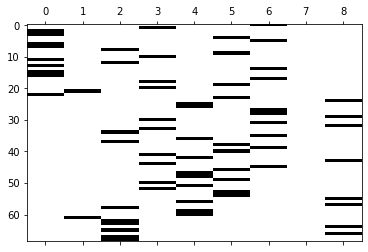

In [ ]:
fig, ax = plt.subplots()
ax.matshow(labels_pred, cmap=plt.cm.Greys, aspect='auto')